In [1]:
rm(list = ls())           
library(tidyverse)
library(lubridate)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
setwd("/home/jovyan")

getwd()
dir.exists("data")
if (!dir.exists("data")) dir.create("data")

[1] "/home/jovyan"

[1] TRUE

In [3]:
file.access("data", 2)   

data 
   0

# 1. Загрузка данных (Airbnb NYC 2019)

In [4]:
url <- "https://raw.githubusercontent.com/Siddharth1698/New-York-City-Airbnb-Data-Case-Study/main/AB_NYC_2019.csv"

raw <- read_csv(url)

cat("Размер исходного датасета:\n")
print(dim(raw))  

glimpse(raw)

Rows: 48895 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (5): name, host_name, neighbourhood_group, neighbourhood, room_type
dbl  (10): id, host_id, latitude, longitude, price, minimum_nights, number_o...
date  (1): last_review

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Размер исходного датасета:
[1] 48895    16
Rows: 48,895
Columns: 16
$ id                             <dbl> 2539, 2595, 3647, 3831, 5022, 5099, 512…
$ name                           <chr> "Clean & quiet apt home by the park", "…
$ host_id                        <dbl> 2787, 2845, 4632, 4869, 7192, 7322, 735…
$ host_name                      <chr> "John", "Jennifer", "Elisabeth", "LisaR…
$ neighbourhood_group            <chr> "Brooklyn", "Manhattan", "Manhattan", "…
$ neighbourhood                  <chr> "Kensington", "Midtown", "Harlem", "Cli…
$ latitude                       <dbl> 40.64749, 40.75362, 40.80902, 40.68514,…
$ longitude                      <dbl> -73.97237, -73.98377, -73.94190, -73.95…
$ room_type                      <chr> "Private room", "Entire home/apt", "Pri…
$ price                          <dbl> 149, 225, 150, 89, 80, 200, 60, 79, 79,…
$ minimum_nights                 <dbl> 1, 1, 3, 1, 10, 3, 45, 2, 2, 1, 5, 2, 4…
$ number_of_reviews              <dbl> 9, 45, 0, 270

# 2. Базовая чистка и приведение типов

In [5]:
df <- raw %>%
  mutate(
    last_review = ymd(last_review),           # даты
    neighbourhood_group = as.factor(neighbourhood_group),
    neighbourhood       = as.factor(neighbourhood),
    room_type           = as.factor(room_type)
  )

# 3. Пропуски

In [6]:
na_counts <- df %>%
  summarise(across(everything(), ~ sum(is.na(.)))) %>%
  pivot_longer(cols = everything(),
               names_to = "feature", values_to = "na_count")

cat("Пропуски по признакам:\n")
print(na_counts)

Пропуски по признакам:
# A tibble: 16 × 2
   feature                        na_count
   <chr>                             <int>
 1 id                                    0
 2 name                                 16
 3 host_id                               0
 4 host_name                            21
 5 neighbourhood_group                   0
 6 neighbourhood                         0
 7 latitude                              0
 8 longitude                             0
 9 room_type                             0
10 price                                 0
11 minimum_nights                        0
12 number_of_reviews                     0
13 last_review                       10052
14 reviews_per_month                 10052
15 calculated_host_listings_count        0
16 availability_365                      0


# reviews_per_month: NA → 0 (нет отзывов)

In [7]:
df <- df %>%
  mutate(
    reviews_per_month = replace_na(reviews_per_month, 0)
  )

# last_review можно оставить с NA, для кластеризации он нам не нужен

# 4. Дубликаты

In [8]:
n_dup <- sum(duplicated(df))
cat("Количество дубликатов:", n_dup, "\n")

df <- df %>% distinct()

Количество дубликатов: 0 


# 5. Удаление неинформативных признаков

In [9]:
df <- df %>%
  select(-id, -name, -host_name, -last_review)

# 6. Обработка выбросов

# Уберем объявления с некорректной ценой

In [10]:
df <- df %>%
  filter(price > 0)

# Ограничим экстремальные цены (очень дорогие виллы)

In [11]:
df <- df %>%
  filter(price < 500)

# Ограничим минимальное число ночей, чтобы убрать странные значения

In [12]:
df <- df %>%
  filter(minimum_nights <= 365)

# 7. Выбросы по IQR для основных числовых признаков

In [13]:
num_cols <- df %>% select(where(is.numeric)) %>% colnames()

In [14]:
remove_outliers_iqr <- function(x) {
  q1 <- quantile(x, 0.25, na.rm = TRUE)
  q3 <- quantile(x, 0.75, na.rm = TRUE)
  iqr <- q3 - q1
  low <- q1 - 1.5 * iqr
  high <- q3 + 1.5 * iqr
  x[x < low | x > high] <- NA
  x
}

In [15]:
df <- df %>%
  mutate(across(all_of(num_cols), remove_outliers_iqr)) %>%
  mutate(across(all_of(num_cols),
                ~ ifelse(is.na(.), median(., na.rm = TRUE), .)))

cat("Размер датасета после очистки:\n")
print(dim(df))

Размер датасета после очистки:
[1] 47635    12


# 8. Пара простых визуализаций

# Гистограмма цен

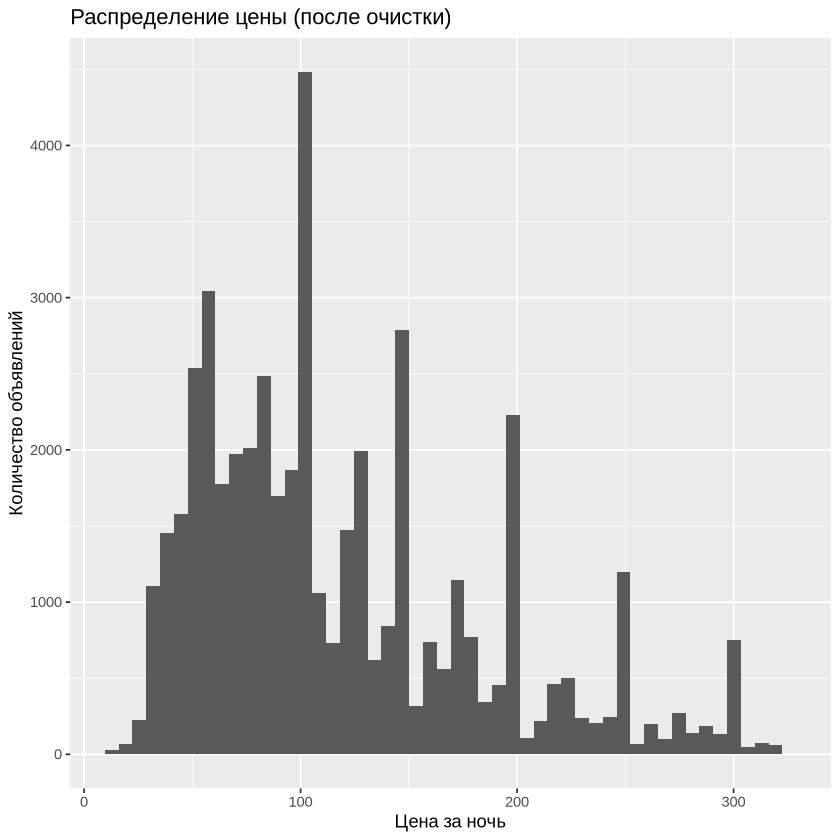

In [16]:
ggplot(df, aes(x = price)) +
  geom_histogram(bins = 50) +
  labs(title = "Распределение цены (после очистки)",
       x = "Цена за ночь", y = "Количество объявлений")

# Boxplot по количеству отзывов и минимальным ночам

In [17]:
df_long <- df %>%
  select(price, minimum_nights, number_of_reviews, reviews_per_month,
         calculated_host_listings_count, availability_365) %>%
  pivot_longer(everything(), names_to = "feature", values_to = "value")

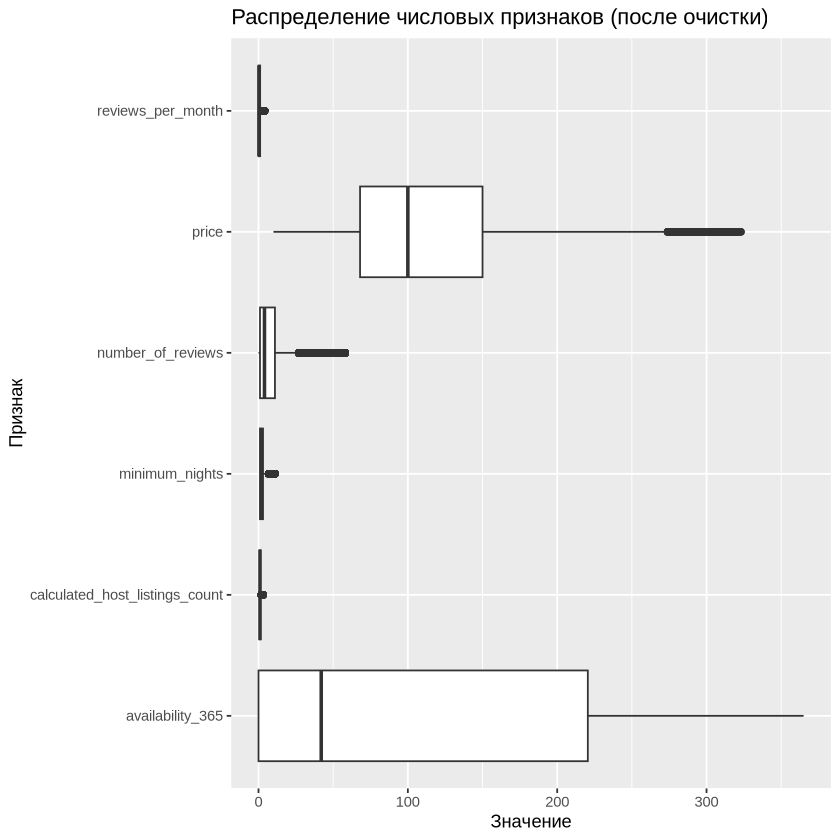

In [18]:
ggplot(df_long, aes(x = feature, y = value)) +
  geom_boxplot() +
  coord_flip() +
  labs(title = "Распределение числовых признаков (после очистки)",
       x = "Признак", y = "Значение")

# 9. Сохранение очищенного датасета

In [20]:
write_csv(df, "data/airbnb_clean.csv")

cat("ГОТОВО: сохранено в data/airbnb_clean.csv\n")
list.files("data")

ГОТОВО: сохранено в data/airbnb_clean.csv


[1] "airbnb_clean.csv"